# Mutli-Class Classifier

## Load Datasets

In [1]:
import pandas as pd

PaCMAP_path = '../Data/Processed_Data/PaCMAP_Results/'
input_path = '../Data/Processed_Data/'
output_path = '../Data/Processed_Data/'

x_train = pd.read_pickle(PaCMAP_path+'embedding.pkl')
x_test = pd.read_pickle(PaCMAP_path+'embedding_test.pkl')

y = pd.read_csv(input_path+'y.csv', index_col=0)
y['PaCMAP Output'] = 'Patient Samples at Diagnosis'

labels = pd.read_excel(input_path+'y_plus_WHOclass.xlsx', index_col=0)['WHO Classification']

y = y.join(labels.to_frame('WHO Classification'))
y['KMT2A Fusions'] = y[y['WHO Classification'].isin(['AML with KMT2A-rearrangement'])]['Gene Fusion'] 

y_train = y[~y['Clinical Trial'].isin(['AML02','AML08'])]
y_test = y[y['Clinical Trial'].isin(['AML02','AML08'])]

y_train = y_train[y_train['WHO Classification'].notnull()]
y_test = y_test[y_test['WHO Classification'].notnull()]

x_train = x_train.loc[y_train.index].to_numpy()
x_test = x_test.loc[y_test.index].to_numpy()

## Train and Test Classifier

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

parameters = {}

estimator = GaussianProcessClassifier(random_state=42 )

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 3,
    verbose=True,
)

grid_search.fit(x_train,y_train['WHO Classification'])

model = grid_search.best_estimator_.fit(x_train,y_train['WHO Classification'])
clf = grid_search.best_estimator_


clf.fit(x_train, y_train['WHO Classification'])
y_pred = clf.predict(x_test)

# print score of y_pred
print(f'ROC AUC of GPC classifier on test set: {clf.score(x_test, y_test["WHO Classification"]):.2f}')
print(f'ROC AUC of GPC classifier on train set: {clf.score(x_train, y_train["WHO Classification"]):.2f}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits


c:\Users\flourenco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan]
  warnings.warn(


ROC AUC of GPC classifier on test set: 0.80
ROC AUC of GPC classifier on train set: 0.92


## Evaluate Results by Class

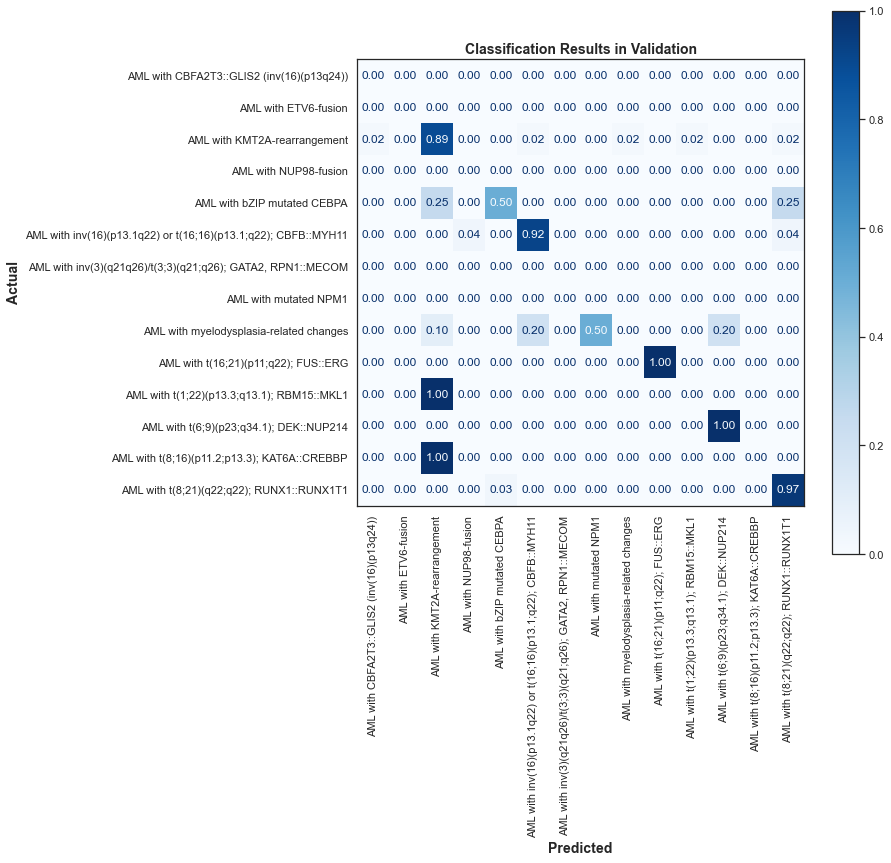

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')
predictions = clf.predict(x_test)
cm = confusion_matrix(y_test['WHO Classification'], predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_,
                            )
disp.plot( cmap='Blues', values_format='.2f', xticks_rotation='vertical')

# Increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(10, 10)

# Add title and axis names
plt.title('Classification Results in Validation', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')



plt.show()

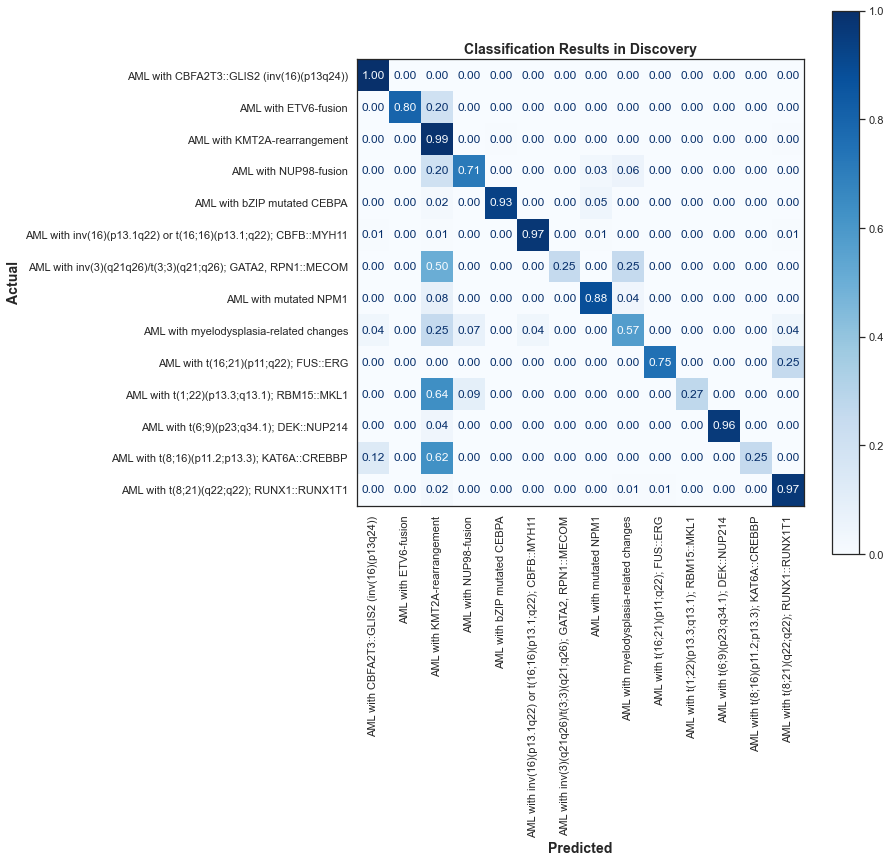

In [8]:
predictions = clf.predict(x_train)
cm = confusion_matrix(y_train['WHO Classification'], predictions, labels=clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_,
                            )
disp.plot( cmap='Blues', values_format='.2f', xticks_rotation='vertical')

# Increase the size of the plot
fig = plt.gcf()
fig.set_size_inches(10, 10)

# Add title and axis names
plt.title('Classification Results in Discovery', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')



plt.show()

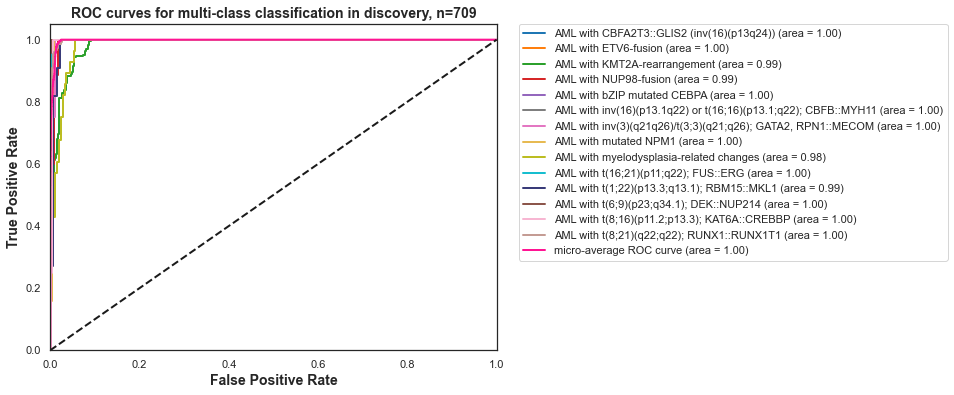

c:\Users\flourenco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\flourenco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\flourenco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\flourenco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\flourenco\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_rankin

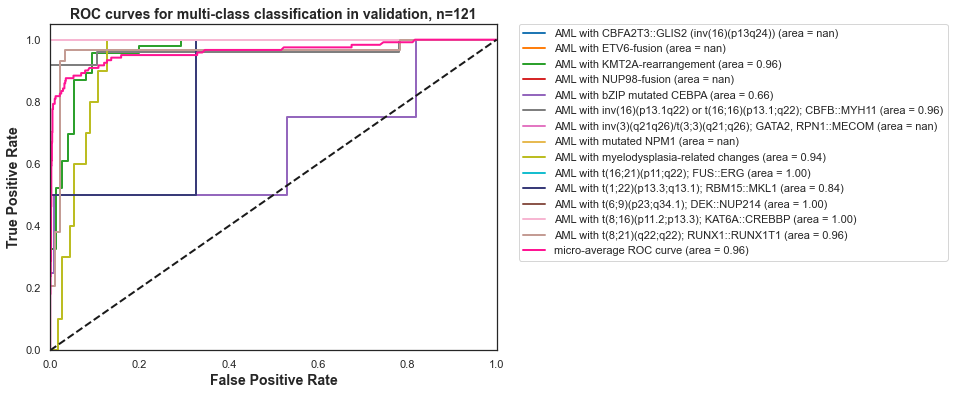

In [86]:
def plot_roc_curve(clf, x, y, dataset):
    y_score = clf.predict_proba(x)
    from sklearn.preprocessing import label_binarize

    # Binarize the labels to plot ROC curves for each class
    y_bin = label_binarize(y, classes=clf.classes_)
    n_classes = y_bin.shape[1]
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves for each class and micro-average ROC curve
    plt.figure(figsize=(8, 6))
    colors = custom_color_palette = [
        '#1f77b4',
        '#ff7f0e', 
        '#2ca02c',
        '#d62728',
        '#9467bd', 
        '#7f7f7f',
        '#e377c2',
        '#e7ba52',
        '#bcbd22',
        '#17becf',
        '#393b79',
        '#8c564b',
        '#f7b6d2',
        '#c49c94']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (area = {1:0.2f})'
                ''.format(clf.classes_[i], roc_auc[i]))

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2,
            label='micro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc["micro"]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
    plt.title('ROC curves for multi-class classification in ' + dataset + ', n=' + str(len(x)), fontsize=14, fontweight='bold')
    # plot legend outside of plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

plot_roc_curve(clf, x_train, y_train['WHO Classification'], 'discovery')
plot_roc_curve(clf, x_test, y_test['WHO Classification'], 'validation')
